# PhysioNet EEG-ARNN Training Pipeline

This notebook implements the complete training pipeline with:
- Subject-specific 3-fold cross-validation
- Edge Selection (ES) and Aggregation Selection (AS)
- Experiments with different k values (10, 15, 20, 25)
- Comprehensive results and visualizations

## Setup and Imports

In [3]:
import sys
from pathlib import Path
import warnings
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import mne

# IMPORTANT: Force reload train_utils to get latest fixes
import importlib
import train_utils
importlib.reload(train_utils)

from models import EEGARNN, ChannelSelector
from train_utils import (
    load_preprocessed_data, filter_classes, normalize_data,
    cross_validate_subject, EEGDataset
)

warnings.filterwarnings('ignore')
mne.set_log_level('ERROR')
sns.set_context('notebook', font_scale=1.1)
plt.style.use('seaborn-v0_8')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Verify the fix is loaded
print("\n" + "="*80)
print("VERIFICATION: Checking if train_utils.py fix is loaded...")
print("="*80)
import inspect
source = inspect.getsource(load_preprocessed_data)
if 'events_from_annotations' in source:
    print("✓ GOOD: train_utils.py has the annotations fix!")
else:
    print("✗ ERROR: train_utils.py is still using old code!")
    print("  → Please restart Jupyter kernel: Kernel → Restart Kernel")
    print("  → Then re-run all cells from the top")
print("="*80)

Using device: cpu

VERIFICATION: Checking if train_utils.py fix is loaded...
✓ GOOD: train_utils.py has the annotations fix!


## Configuration

In [4]:

EXPERIMENT_CONFIG = {
    'data': {
        'preprocessed_dir': Path('data/physionet/derived/preprocessed'),
        'index_file': Path('data/physionet/derived/physionet_preprocessed_index.csv'),
        'selected_classes': [1, 2],  # T1, T2 (or [1, 2, 3, 4] for 4-class)
        'tmin': -1.0,
        'tmax': 5.0,
        'baseline': (-0.5, 0)
    },
    'model': {
        'hidden_dim': 40,
        'epochs': 10,
        'learning_rate': 0.001,
        'batch_size': 32,
        'n_folds': 2,
        'patience': 8
    },
    'channel_selection': {
        'k_values': [10, 15, 20, 25, 'all'],
        'methods': ['ES', 'AS', 'Hybrid', 'Centrality', 'Diversity'],
        'hybrid_alpha': 0.7,
        'hybrid_beta': 0.3,
        'centrality_power': 2,
        'diversity_penalty': 0.6
    },
    'output': {
        'results_dir': Path('results'),
        'models_dir': Path('saved_models')
    },
    'max_subjects': 5
}

EXPERIMENT_CONFIG['output']['results_dir'].mkdir(exist_ok=True)
EXPERIMENT_CONFIG['output']['models_dir'].mkdir(exist_ok=True)

print('Experiment Configuration:')
print(json.dumps(EXPERIMENT_CONFIG, indent=2, default=str))


Experiment Configuration:
{
  "data": {
    "preprocessed_dir": "data\\physionet\\derived\\preprocessed",
    "index_file": "data\\physionet\\derived\\physionet_preprocessed_index.csv",
    "selected_classes": [
      1,
      2
    ],
    "tmin": -1.0,
    "tmax": 5.0,
    "baseline": [
      -0.5,
      0
    ]
  },
  "model": {
    "hidden_dim": 40,
    "epochs": 10,
    "learning_rate": 0.001,
    "batch_size": 32,
    "n_folds": 2,
    "patience": 8
  },
  "channel_selection": {
    "k_values": [
      10,
      15,
      20,
      25,
      "all"
    ],
    "methods": [
      "ES",
      "AS",
      "Hybrid",
      "Centrality",
      "Diversity"
    ],
    "hybrid_alpha": 0.7,
    "hybrid_beta": 0.3,
    "centrality_power": 2,
    "diversity_penalty": 0.6
  },
  "output": {
    "results_dir": "results",
    "models_dir": "saved_models"
  },
  "max_subjects": 5
}


## Load Preprocessed Data Index

In [5]:
index_df = pd.read_csv(EXPERIMENT_CONFIG['data']['index_file'])
success_df = index_df[index_df['status'] == 'success'].copy()

print(f"Total preprocessed runs: {len(index_df)}")
print(f"Successful runs: {len(success_df)}")
print(f"\nSubjects available: {success_df['subject'].nunique()}")
print(f"\nRuns per category:")
print(success_df.groupby('category')['run'].count())

success_df.head()

Total preprocessed runs: 669
Successful runs: 669

Subjects available: 51

Runs per category:
category
motor_execution    292
motor_imagery      295
resting_state       82
Name: run, dtype: int64


,subject,run,status,path,timestamp,original_sfreq,n_channels_original,duration_s,bad_channels,n_bad_channels,notch_applied,final_sfreq,n_channels_final,file_size_mb,category,task,bad_channels_interpolated
0,S001,R01,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:21.734828,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes open,NaN
1,S001,R02,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.079682,160.0,64,60.99375,[],0,[50.0],128.0,64,1.917076,resting_state,Baseline eyes closed,NaN
2,S001,R04,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.304813,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close right fist (executed),NaN
3,S001,R05,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:22.684043,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both fists (executed),NaN
4,S001,R06,success,data\physionet\derived\preprocessed\S001\S001R...,2025-10-28T09:06:23.086544,160.0,64,124.99375,[],0,[50.0],128.0,64,3.918468,motor_execution,Open/close both feet (executed),NaN


## Subject Selection

Select subjects for training. For motor imagery, we focus on motor execution and motor imagery runs.

In [6]:
# Filter motor-related runs (execution and imagery)
motor_runs = success_df[success_df['category'].isin(['motor_execution', 'motor_imagery'])].copy()

# Count runs per subject
subject_counts = motor_runs.groupby('subject').size().reset_index(name='num_runs')
subject_counts = subject_counts[subject_counts['num_runs'] >= 10]  # At least 10 runs

selected_subjects = subject_counts['subject'].tolist()

print(f"Subjects with >=10 motor runs: {len(selected_subjects)}")
print(f"\nFirst 10 subjects: {selected_subjects[:10]}")

# Limit to max_subjects for this experiment
max_subjects = EXPERIMENT_CONFIG.get('max_subjects', len(selected_subjects))
selected_subjects = selected_subjects[:max_subjects]

print(f"\nWill train on {len(selected_subjects)} subjects")
print(f"Selected subjects: {selected_subjects}")

Subjects with >=10 motor runs: 49

First 10 subjects: ['S001', 'S002', 'S005', 'S006', 'S007', 'S008', 'S011', 'S014', 'S015', 'S016']

Will train on 5 subjects
Selected subjects: ['S001', 'S002', 'S005', 'S006', 'S007']


## Helper Functions

In [7]:
def load_subject_data(subject_id, preprocessed_dir, motor_runs_df, config):
    """
    Load all motor runs for a subject and concatenate
    
    Returns
    -------
    data : np.ndarray or None
        (n_trials, n_channels, n_timepoints)
    labels : np.ndarray or None
        (n_trials,)
    channel_names : list
        List of channel names
    """
    subject_runs = motor_runs_df[motor_runs_df['subject'] == subject_id]
    
    all_data = []
    all_labels = []
    channel_names = None
    
    for _, run_info in subject_runs.iterrows():
        fif_path = Path(run_info['path'])
        
        if not fif_path.exists():
            continue
        
        try:
            data, labels = load_preprocessed_data(
                fif_path,
                tmin=config['data']['tmin'],
                tmax=config['data']['tmax'],
                baseline=config['data']['baseline']
            )
            
            if data is not None and len(data) > 0:
                all_data.append(data)
                all_labels.append(labels)
                
                if channel_names is None:
                    raw = mne.io.read_raw_fif(fif_path, preload=False, verbose='ERROR')
                    channel_names = raw.ch_names
                    
        except Exception as e:
            print(f"Error loading {fif_path.name}: {e}")
            continue
    
    if len(all_data) == 0:
        return None, None, None
    
    all_data = np.concatenate(all_data, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Filter to selected classes
    all_data, all_labels = filter_classes(
        all_data, all_labels, config['data']['selected_classes']
    )
    
    return all_data, all_labels, channel_names

### Advanced Channel Selection Utilities

Reusable helpers for hybrid scoring, centrality-based ranking, and diversity-aware greedy selection.

In [8]:
import numpy.linalg as LA


def _normalize_scores(scores: np.ndarray) -> np.ndarray:
    scores = np.asarray(scores, dtype=np.float64)
    if np.allclose(scores.max(), scores.min()):
        return np.ones_like(scores) / max(len(scores), 1)
    scores = (scores - scores.min()) / (scores.max() - scores.min())
    return scores


def hybrid_channel_scores(adj_matrix: np.ndarray, alpha: float = 0.7, beta: float = 0.3, power: int = 2) -> np.ndarray:
    # Combine first- and second-order connectivity to score channels.
    A = np.abs(adj_matrix)
    node_strength = A.sum(axis=1)
    second_order = np.abs(LA.matrix_power(A, max(power, 1))).sum(axis=1) if power > 1 else node_strength
    node_strength = _normalize_scores(node_strength)
    second_order = _normalize_scores(second_order)
    return alpha * node_strength + beta * second_order


def eigen_centrality_scores(adj_matrix: np.ndarray, power: int = 2, tol: float = 1e-6, max_iter: int = 100) -> np.ndarray:
    # Approximate eigenvector centrality via power iteration on |A|.
    A = np.abs(adj_matrix)
    if power > 1:
        A = LA.matrix_power(A, power)
    n = A.shape[0]
    vec = np.ones(n) / max(n, 1)
    for _ in range(max_iter):
        new_vec = A @ vec
        norm = LA.norm(new_vec, ord=2)
        if norm == 0:
            break
        new_vec /= norm
        if LA.norm(new_vec - vec, ord=2) < tol:
            vec = new_vec
            break
        vec = new_vec
    return _normalize_scores(vec)


def diversity_greedy_selection(adj_matrix: np.ndarray, base_scores: np.ndarray, k: int, penalty: float = 0.6) -> np.ndarray:
    # Greedy selection that penalizes redundant picks strongly connected to chosen nodes.
    if k >= len(base_scores):
        return np.arange(len(base_scores))

    A = np.abs(adj_matrix)
    scores = base_scores.copy()
    selected = []
    available = set(range(len(base_scores)))

    while len(selected) < k and available:
        best_idx = max(available, key=lambda idx: scores[idx])
        selected.append(best_idx)
        available.remove(best_idx)

        for idx in list(available):
            scores[idx] -= penalty * A[best_idx, idx]
        scores[best_idx] = -np.inf

    return np.array(sorted(selected))


def get_channel_selection(adj_matrix: np.ndarray,
                          channel_names: list,
                          method: str,
                          k: int,
                          cfg: dict):
    # Return (names, indices) for the requested selection method.
    method = method.upper()
    num_channels = len(channel_names)

    if k >= num_channels:
        indices = np.arange(num_channels)
        return channel_names, indices

    selector = ChannelSelector(adj_matrix, channel_names)

    if method == 'ES':
        names, indices = selector.edge_selection(k)
    elif method == 'AS':
        names, indices = selector.aggregation_selection(k)
    elif method == 'HYBRID':
        alpha = cfg.get('hybrid_alpha', 0.7)
        beta = cfg.get('hybrid_beta', 0.3)
        power = cfg.get('centrality_power', 2)
        scores = hybrid_channel_scores(adj_matrix, alpha=alpha, beta=beta, power=power)
        indices = np.argsort(scores)[-k:]
        indices = np.sort(indices)
        names = [channel_names[idx] for idx in indices]
    elif method == 'CENTRALITY':
        power = cfg.get('centrality_power', 2)
        scores = eigen_centrality_scores(adj_matrix, power=power)
        indices = np.argsort(scores)[-k:]
        indices = np.sort(indices)
        names = [channel_names[idx] for idx in indices]
    elif method == 'DIVERSITY':
        alpha = cfg.get('hybrid_alpha', 0.7)
        beta = cfg.get('hybrid_beta', 0.3)
        base_scores = hybrid_channel_scores(adj_matrix, alpha=alpha, beta=beta, power=cfg.get('centrality_power', 2))
        penalty = cfg.get('diversity_penalty', 0.6)
        indices = diversity_greedy_selection(adj_matrix, base_scores, k, penalty=penalty)
        names = [channel_names[idx] for idx in indices]
    else:
        raise ValueError(f"Unknown channel selection method: {method}")

    return names, indices


In [12]:
# in your notebook (cell)
import importlib
import train_utils
importlib.reload(train_utils)


<module 'train_utils' from 'c:\\Users\\Sujal Bhatu\\Desktop\\EEG_ML\\eeg_shared\\eeg-channel-selection\\train_utils.py'>

## Main Training Loop

Train subject-specific models with 3-fold cross-validation

In [13]:
all_results = []

for subject_id in tqdm(selected_subjects, desc="Training subjects"):
    print(f"\n{'='*80}")
    print(f"Training subject: {subject_id}")
    print(f"{'='*80}")
    
    # Load subject data
    data, labels, channel_names = load_subject_data(
        subject_id, 
        EXPERIMENT_CONFIG['data']['preprocessed_dir'],
        motor_runs,
        EXPERIMENT_CONFIG
    )
    
    if data is None or len(data) < 30:  # Need at least 30 trials for 3-fold CV
        print(f"Skipping {subject_id}: insufficient data")
        continue
    
    print(f"Data shape: {data.shape}")
    print(f"Labels: {np.unique(labels, return_counts=True)}")
    print(f"Channels: {len(channel_names)}")
    
    num_channels = data.shape[1]
    num_timepoints = data.shape[2]
    num_classes = len(np.unique(labels))
    
    # Perform 3-fold cross-validation
    cv_results = cross_validate_subject(
        data, labels,
        num_channels=num_channels,
        num_timepoints=num_timepoints,
        num_classes=num_classes,
        device=device,
        n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
        epochs=EXPERIMENT_CONFIG['model']['epochs'],
        lr=EXPERIMENT_CONFIG['model']['learning_rate']
    )
    
    print(f"\nAverage accuracy (all channels): {cv_results['avg_accuracy']:.4f} ± {cv_results['std_accuracy']:.4f}")
    
    # Save results
    result = {
        'subject': subject_id,
        'num_trials': len(data),
        'num_channels': num_channels,
        'num_timepoints': num_timepoints,
        'num_classes': num_classes,
        'all_channels_acc': cv_results['avg_accuracy'],
        'all_channels_std': cv_results['std_accuracy'],
        'adjacency_matrix': cv_results['adjacency_matrix'],
        'channel_names': channel_names
    }
    
    all_results.append(result)

print(f"\n{'='*80}")
print(f"Training complete for {len(all_results)} subjects")
print(f"{'='*80}")

Training subjects:   0%|          | 0/5 [00:00<?, ?it/s]


Training subject: S001
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))
Channels: 64
  Fold 1/2 -> Acc: 0.759 (stopped at epoch 10)
  Fold 2/2 -> Acc: 0.748 (stopped at epoch 10)

Average accuracy (all channels): 0.7532 ± 0.0054

Training subject: S002
Data shape: (231, 64, 769)
Labels: (array([0, 1]), array([154,  77]))
Channels: 64
  Fold 1/2 -> Acc: 0.664 (stopped at epoch 10)
  Fold 2/2 -> Acc: 0.687 (stopped at epoch 10)

Average accuracy (all channels): 0.6754 ± 0.0116

Training subject: S005
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84]))
Channels: 64
  Fold 1/2 -> Acc: 0.452 (stopped at epoch 10)
  Fold 2/2 -> Acc: 0.619 (stopped at epoch 10)

Average accuracy (all channels): 0.5357 ± 0.0833

Training subject: S006
Data shape: (252, 64, 769)
Labels: (array([0, 1]), array([168,  84]))
Channels: 64
  Fold 1/2 -> Acc: 0.690 (stopped at epoch 10)
  Fold 2/2 -> Acc: 0.460 (stopped at epoch 10)

Average accuracy (all channels): 0.5754 ± 0.1

## Channel Selection Experiments

Test different k values with Edge Selection and Aggregation Selection

In [15]:
channel_selection_results = []

if len(all_results) > 0:
    selection_cfg = EXPERIMENT_CONFIG['channel_selection']

    for result in tqdm(all_results, desc="Channel selection experiments"):
        subject_id = result['subject']
        adj_matrix = result['adjacency_matrix']
        channel_names = result['channel_names']

        print(f"Processing channel selection for {subject_id}")

        for method in selection_cfg['methods']:
            print(f"  Method: {method}")

            for k in selection_cfg['k_values']:
                if k == 'all':
                    k_val = result['num_channels']
                    selected_channels = list(channel_names)
                    selected_indices = np.arange(result['num_channels'])
                else:
                    k_val = min(k, result['num_channels'])
                    selected_channels, selected_indices = get_channel_selection(
                        adj_matrix,
                        channel_names,
                        method,
                        k_val,
                        selection_cfg
                    )

                print(f"    k={k_val}: {len(selected_channels)} channels selected")
                channel_selection_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'selected_indices': selected_indices.tolist(),
                    'accuracy_full': result['all_channels_acc']
                })

    channel_selection_df = pd.DataFrame(channel_selection_results)
    print(f"0Channel selection results: {len(channel_selection_df)} experiments")
    display(channel_selection_df.head(10))
else:
    channel_selection_df = pd.DataFrame()
    print("No results available for channel selection experiments.")

Channel selection experiments:   0%|          | 0/5 [00:00<?, ?it/s]

Processing channel selection for S001
  Method: ES
    k=10: 16 channels selected
    k=15: 23 channels selected
    k=20: 28 channels selected
    k=25: 34 channels selected
    k=64: 64 channels selected
  Method: AS
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected
  Method: Hybrid
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected
  Method: Centrality
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected
  Method: Diversity
    k=10: 10 channels selected
    k=15: 15 channels selected
    k=20: 20 channels selected
    k=25: 25 channels selected
    k=64: 64 channels selected
Processing channel selection for S002
  Method: ES
    k=10: 17 channels selected
    k=15: 23 channels

,subject,method,k,num_selected,selected_channels,selected_indices,accuracy_full
0,S001,ES,10,16,"[Fc3, Fc2, C5, Cp5, Cp3, Cpz, Cp2, Fp1, Fpz, A...","[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223
1,S001,ES,15,23,"[Fc3, Fc2, C5, Cz, C2, C6, Cp5, Cp3, Cpz, Cp2,...","[1, 4, 7, 10, 11, 13, 14, 15, 17, 18, 21, 22, ...",0.753223
2,S001,ES,20,28,"[Fc3, Fc2, Fc6, C5, Cz, C2, C6, Cp5, Cp3, Cpz,...","[1, 4, 6, 7, 10, 11, 13, 14, 15, 17, 18, 21, 2...",0.753223
3,S001,ES,25,34,"[Fc3, Fc1, Fc2, Fc6, C5, Cz, C2, C6, Cp5, Cp3,...","[1, 2, 4, 6, 7, 10, 11, 13, 14, 15, 16, 17, 18...",0.753223
4,S001,ES,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.753223
5,S001,AS,10,10,"[C2, Cp1, Fp1, Fpz, Fp2, Afz, Af4, Tp7, P7, Oz]","[11, 16, 21, 22, 23, 26, 27, 44, 46, 61]",0.753223
6,S001,AS,15,15,"[Fcz, C2, Cp3, Cp1, Fp1, Fpz, Fp2, Afz, Af4, F...","[3, 11, 15, 16, 21, 22, 23, 26, 27, 39, 42, 44...",0.753223
7,S001,AS,20,20,"[Fc3, Fcz, C1, C2, Cp3, Cp1, Fp1, Fpz, Fp2, Af...","[1, 3, 9, 11, 15, 16, 21, 22, 23, 26, 27, 37, ...",0.753223
8,S001,AS,25,25,"[Fc3, Fcz, C5, C1, C2, C4, Cp3, Cp1, Fp1, Fpz,...","[1, 3, 7, 9, 11, 12, 15, 16, 21, 22, 23, 26, 2...",0.753223
9,S001,AS,64,64,"[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.753223


### Channel Selection Method Summary

Quick diagnostics on how each strategy ranks channels across subjects and k values.

In [19]:
# 1) prepare exploded table
exploded = selection_df[~selection_df['is_full']].explode('selected_channels')

# 2) counts per (method, k, channel)
counts = (
    exploded
    .groupby(['method', 'k', 'selected_channels'])
    .size()
    .reset_index(name='count')
)

# 3) ratio within each (method, k)
counts['selection_ratio'] = counts.groupby(['method', 'k'])['count'].transform(lambda x: x / x.sum())

# 4) pick top 10 channels per (method, k)
channel_freq = (
    counts
    .sort_values(['method', 'k', 'selection_ratio'], ascending=[True, True, False])
    .groupby(['method', 'k'])
    .head(10)
    .reset_index(drop=True)
)

print('Top channels per method and k (ratio within method/k):')
display(channel_freq[['method', 'k', 'selected_channels', 'selection_ratio', 'count']])


Top channels per method and k (ratio within method/k):


,method,k,selected_channels,selection_ratio,count
0,ES,10,C2,0.047619,4
1,ES,10,Cp2,0.047619,4
2,ES,10,P6,0.047619,4
3,ES,10,C5,0.035714,3
4,ES,10,Cp3,0.035714,3
5,ES,10,Fc3,0.035714,3
6,ES,10,Fp1,0.035714,3
7,ES,10,Ft7,0.035714,3
8,ES,10,Af3,0.023810,2
9,ES,10,Af4,0.023810,2


In [20]:
print(selection_df.columns.tolist())
print(selection_df.head(3).to_dict(orient='list'))
print(exploded.head(6))
print(counts.head(6))


['subject', 'method', 'k', 'num_selected', 'selected_channels', 'selected_indices', 'accuracy_full', 'is_full']
{'subject': ['S001', 'S001', 'S001'], 'method': ['ES', 'ES', 'ES'], 'k': [10, 15, 20], 'num_selected': [16, 23, 28], 'selected_channels': [['Fc3', 'Fc2', 'C5', 'Cp5', 'Cp3', 'Cpz', 'Cp2', 'Fp1', 'Fpz', 'Af4', 'P7', 'P6', 'Po3', 'Po4', 'Po8', 'Oz'], ['Fc3', 'Fc2', 'C5', 'Cz', 'C2', 'C6', 'Cp5', 'Cp3', 'Cpz', 'Cp2', 'Fp1', 'Fpz', 'Af4', 'Tp7', 'P7', 'P1', 'P6', 'Po7', 'Po3', 'Po4', 'Po8', 'Oz', 'Iz'], ['Fc3', 'Fc2', 'Fc6', 'C5', 'Cz', 'C2', 'C6', 'Cp5', 'Cp3', 'Cpz', 'Cp2', 'Fp1', 'Fpz', 'Af4', 'F5', 'F3', 'Tp7', 'P7', 'P5', 'P1', 'P6', 'Po7', 'Po3', 'Po4', 'Po8', 'O1', 'Oz', 'Iz']], 'selected_indices': [[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, 56, 58, 59, 61], [1, 4, 7, 10, 11, 13, 14, 15, 17, 18, 21, 22, 27, 44, 46, 49, 53, 55, 56, 58, 59, 61, 63], [1, 4, 6, 7, 10, 11, 13, 14, 15, 17, 18, 21, 22, 27, 30, 31, 44, 46, 47, 49, 53, 55, 56, 58, 59, 60, 61, 63]], 'accuracy_ful

In [21]:
import pandas as pd
selection_df = pd.DataFrame([
    {'method':'A','k':3,'num_selected':5,'selected_channels':['C1','C2']},
    {'method':'A','k':3,'num_selected':5,'selected_channels':['C1','C3']},
    {'method':'A','k':2,'num_selected':2,'selected_channels':['C2','C4']},  # will be filtered by is_full below
    {'method':'B','k':1,'num_selected':4,'selected_channels':['C5']},
])
selection_df['is_full'] = selection_df['k'] == selection_df['num_selected']

# paste the main code here (exploded / counts / selection_ratio / channel_freq)


In [26]:
# exploded already defined above
exploded = selection_df[~selection_df['is_full']].explode('selected_channels')

# counts per (method, k, channel)
counts = (
    exploded
    .groupby(['method', 'k', 'selected_channels'])
    .size()
    .reset_index(name='count')
)

# ratio within each (method, k)
counts['selection_ratio'] = counts.groupby(['method', 'k'])['count'].transform(lambda x: x / x.sum())

# top 10 channels per (method, k)
channel_freq = (
    counts
    .sort_values(['method', 'k', 'selection_ratio'], ascending=[True, True, False])
    .groupby(['method', 'k'])
    .head(10)
    .reset_index(drop=True)
)

print('Top channels per method and k (ratio within method/k):')
display(channel_freq[['method', 'k', 'selected_channels', 'selection_ratio', 'count']])


Top channels per method and k (ratio within method/k):


,method,k,selected_channels,selection_ratio,count
0,ES,10,C2,0.047619,4
1,ES,10,Cp2,0.047619,4
2,ES,10,P6,0.047619,4
3,ES,10,C5,0.035714,3
4,ES,10,Cp3,0.035714,3
5,ES,10,Fc3,0.035714,3
6,ES,10,Fp1,0.035714,3
7,ES,10,Ft7,0.035714,3
8,ES,10,Af3,0.023810,2
9,ES,10,Af4,0.023810,2


In [29]:
# === Sanity + robust top-channel computation for channel_selection_df ===
# (Run this after the code that creates `channel_selection_df`)

# quick fix for a tiny typo in your earlier print
try:
    print(f"Channel selection results: {len(channel_selection_df)} experiments")
except NameError:
    print("channel_selection_df not defined — did channel selection run?")

# ensure selected_channels are lists (explode needs lists or scalars)
def _ensure_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, (np.ndarray, tuple)):
        return list(x)
    if pd.isna(x):
        return []
    # if it's a single item (str/int), wrap it
    return [x]

if 'selected_channels' in channel_selection_df.columns:
    channel_selection_df['selected_channels'] = channel_selection_df['selected_channels'].apply(_ensure_list)
else:
    raise RuntimeError("channel_selection_df missing 'selected_channels' column")

# mark full selections (k == num_selected)
channel_selection_df['is_full'] = channel_selection_df['k'] == channel_selection_df['num_selected']

# Method counts (same as your original)
method_counts = (
    channel_selection_df[~channel_selection_df['is_full']]
    .groupby(['method', 'k'])
    .size()
    .reset_index(name='experiments')
    .sort_values(['method', 'k'])
)
print('\nExperiments per method/k:')
display(method_counts)

# Explode and compute counts -> ratio (robust; avoids reset_index collisions)
exploded = channel_selection_df[~channel_selection_df['is_full']].explode('selected_channels').reset_index(drop=True)

# remove empty selections if any (defensive)
exploded = exploded[exploded['selected_channels'].notna() & (exploded['selected_channels'] != '')]

# counts per (method, k, channel)
counts = (
    exploded
    .groupby(['method', 'k', 'selected_channels'])
    .size()
    .reset_index(name='count')
)

# ratio within each (method, k)
counts['selection_ratio'] = counts.groupby(['method', 'k'])['count'].transform(lambda x: x / x.sum())

# top 10 channels per (method, k)
channel_freq = (
    counts
    .sort_values(['method', 'k', 'selection_ratio'], ascending=[True, True, False])
    .groupby(['method', 'k'])
    .head(10)
    .reset_index(drop=True)
)

print('\nTop channels per method and k (ratio within method/k):')
display(channel_freq[['method', 'k', 'selected_channels', 'selection_ratio', 'count']])

# Optional: quick sample rows to inspect raw data that produced top channels
print("\nSample raw rows (first 6 exploded rows):")
display(exploded.head(6))


Channel selection results: 125 experiments

Experiments per method/k:


,method,k,experiments
0,ES,10,5
1,ES,15,5
2,ES,20,5
3,ES,25,5



Top channels per method and k (ratio within method/k):


,method,k,selected_channels,selection_ratio,count
0,ES,10,C2,0.047619,4
1,ES,10,Cp2,0.047619,4
2,ES,10,P6,0.047619,4
3,ES,10,C5,0.035714,3
4,ES,10,Cp3,0.035714,3
5,ES,10,Fc3,0.035714,3
6,ES,10,Fp1,0.035714,3
7,ES,10,Ft7,0.035714,3
8,ES,10,Af3,0.023810,2
9,ES,10,Af4,0.023810,2



Sample raw rows (first 6 exploded rows):


,subject,method,k,num_selected,selected_channels,selected_indices,accuracy_full,is_full
0,S001,ES,10,16,Fc3,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False
1,S001,ES,10,16,Fc2,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False
2,S001,ES,10,16,C5,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False
3,S001,ES,10,16,Cp5,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False
4,S001,ES,10,16,Cp3,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False
5,S001,ES,10,16,Cpz,"[1, 4, 7, 14, 15, 17, 18, 21, 22, 27, 46, 53, ...",0.753223,False


In [30]:

if len(channel_selection_results) > 0:
    selection_cfg = EXPERIMENT_CONFIG['channel_selection']
    selection_df = pd.DataFrame(channel_selection_results)
    selection_df['is_full'] = selection_df['k'] == selection_df['num_selected']

    method_counts = (
        selection_df[~selection_df['is_full']]
        .groupby(['method', 'k'])
        .size()
        .reset_index(name='experiments')
        .sort_values(['method', 'k'])
    )
    print('Experiments per method/k:')
    display(method_counts)

    exploded = selection_df[~selection_df['is_full']].explode('selected_channels')
    channel_freq = (
        exploded.groupby(['method', 'k', 'selected_channels'])
        .size()
        .groupby(level=[0, 1])
        .apply(lambda s: (s / s.sum()).sort_values(ascending=False).head(10))
        .reset_index(name='selection_ratio')
    )
    print('Top channels per method and k (ratio within method/k):')
    display(channel_freq)
else:
    print('Channel selection results unavailable ? run the experiments first.')


Experiments per method/k:


,method,k,experiments
0,ES,10,5
1,ES,15,5
2,ES,20,5
3,ES,25,5


ValueError: cannot insert k, already exists

In [31]:

from train_utils import retrain_with_selected_channels

# Store all retraining results
retrain_results = []

if len(all_results) > 0:
    selection_cfg = EXPERIMENT_CONFIG['channel_selection']
    subject_data_cache = {}

    for result in all_results:
        subject_id = result['subject']
        print(f"Loading data for {subject_id}")

        data, labels, channel_names = load_subject_data(
            subject_id,
            EXPERIMENT_CONFIG['data']['preprocessed_dir'],
            motor_runs,
            EXPERIMENT_CONFIG
        )

        if data is None:
            continue

        subject_data_cache[subject_id] = {
            'data': data,
            'labels': labels,
            'channel_names': channel_names
        }

    print(f"{'='*80}")
    print('RETRAINING WITH SELECTED CHANNELS')
    print(f"{'='*80}")

    for result in tqdm(all_results, desc='Retraining subjects'):
        subject_id = result['subject']

        if subject_id not in subject_data_cache:
            continue

        cache = subject_data_cache[subject_id]
        data = cache['data']
        labels = cache['labels']
        channel_names = cache['channel_names']
        adj_matrix = result['adjacency_matrix']

        print(f"Retraining {subject_id}")

        for method in selection_cfg['methods']:
            for k in selection_cfg['k_values']:
                if k == 'all':
                    continue

                k_val = min(k, result['num_channels'])
                selected_channels, selected_indices = get_channel_selection(
                    adj_matrix,
                    channel_names,
                    method,
                    k_val,
                    selection_cfg
                )

                print(f"  {method} k={k_val}: Retraining with {len(selected_channels)} channels...")

                retrain_res = retrain_with_selected_channels(
                    data,
                    labels,
                    selected_channel_indices=np.array(selected_indices),
                    num_timepoints=result['num_timepoints'],
                    num_classes=result['num_classes'],
                    device=device,
                    n_splits=EXPERIMENT_CONFIG['model']['n_folds'],
                    epochs=EXPERIMENT_CONFIG['model']['epochs'],
                    lr=EXPERIMENT_CONFIG['model']['learning_rate']
                )

                acc_drop = result['all_channels_acc'] - retrain_res['avg_accuracy']

                print(f"    Accuracy: {retrain_res['avg_accuracy']:.4f} +/- {retrain_res['std_accuracy']:.4f}")
                print(f"    Drop from full: {acc_drop:.4f} ({acc_drop / result['all_channels_acc'] * 100:.1f}%)")

                retrain_results.append({
                    'subject': subject_id,
                    'method': method,
                    'k': k_val,
                    'num_channels_selected': len(selected_channels),
                    'selected_channels': selected_channels,
                    'accuracy': retrain_res['avg_accuracy'],
                    'std': retrain_res['std_accuracy'],
                    'full_channels_acc': result['all_channels_acc'],
                    'accuracy_drop': acc_drop,
                    'accuracy_drop_pct': acc_drop / result['all_channels_acc'] * 100
                })

    retrain_df = pd.DataFrame(retrain_results)
    print(f"{'='*80}")
    print(f'Retraining complete: {len(retrain_df)} experiments')
    print(f"{'='*80}")

    retrain_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'retrain_results.csv'
    retrain_df.to_csv(retrain_path, index=False)
    print(f"Retrain results saved to: {retrain_path}")
else:
    retrain_df = pd.DataFrame()
    print('No results to retrain. Please run training first.')


Loading data for S001
Loading data for S002
Loading data for S005
Loading data for S006
Loading data for S007
RETRAINING WITH SELECTED CHANNELS


Retraining subjects:   0%|          | 0/5 [00:00<?, ?it/s]

Retraining S001
  ES k=10: Retraining with 16 channels...
    Accuracy: 0.8614 +/- 0.0093
    Drop from full: -0.1082 (-14.4%)
  ES k=15: Retraining with 23 channels...
    Accuracy: 0.8442 +/- 0.0166
    Drop from full: -0.0910 (-12.1%)
  ES k=20: Retraining with 28 channels...
    Accuracy: 0.8009 +/- 0.0165
    Drop from full: -0.0477 (-6.3%)
  ES k=25: Retraining with 34 channels...
    Accuracy: 0.7750 +/- 0.0337
    Drop from full: -0.0218 (-2.9%)
  AS k=10: Retraining with 10 channels...
    Accuracy: 0.5837 +/- 0.1576
    Drop from full: 0.1695 (22.5%)
  AS k=15: Retraining with 15 channels...
    Accuracy: 0.6753 +/- 0.0144
    Drop from full: 0.0780 (10.4%)
  AS k=20: Retraining with 20 channels...
    Accuracy: 0.5581 +/- 0.0798
    Drop from full: 0.1951 (25.9%)
  AS k=25: Retraining with 25 channels...
    Accuracy: 0.7359 +/- 0.0032
    Drop from full: 0.0173 (2.3%)
  Hybrid k=10: Retraining with 10 channels...
    Accuracy: 0.6237 +/- 0.0633
    Drop from full: 0.1296 (1

## Retrain with Selected Channels

Now retrain the model using ONLY the selected channels and compare accuracy

## Results Summary

In [32]:

results_df = pd.DataFrame(all_results)

print("=" * 80)
print("OVERALL RESULTS SUMMARY")
print("=" * 80)
print(f"Subjects trained: {len(results_df)}")

if len(results_df) > 0:
    print(f"Mean accuracy (all channels): {results_df['all_channels_acc'].mean():.4f} +/- {results_df['all_channels_acc'].std():.4f}")
    print(f"Best subject: {results_df.loc[results_df['all_channels_acc'].idxmax(), 'subject']} ({results_df['all_channels_acc'].max():.4f})")
    print(f"Worst subject: {results_df.loc[results_df['all_channels_acc'].idxmin(), 'subject']} ({results_df['all_channels_acc'].min():.4f})")

    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'subject_results.csv'
    results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].to_csv(results_path, index=False)
    print(f"Results saved to: {results_path}")

    display(results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].head(10))
else:
    print("No subjects were successfully trained. Check the data loading and preprocessing steps.")

results_df


OVERALL RESULTS SUMMARY
Subjects trained: 5
Mean accuracy (all channels): 0.6881 +/- 0.1463
Best subject: S007 (0.9008)
Worst subject: S005 (0.5357)
Results saved to: results\subject_results.csv


,subject,num_trials,num_channels,all_channels_acc,all_channels_std
0,S001,231,64,0.753223,0.005397
1,S002,231,64,0.675375,0.011582
2,S005,252,64,0.535714,0.083333
3,S006,252,64,0.575397,0.115079
4,S007,252,64,0.900794,0.019841


,subject,num_trials,num_channels,num_timepoints,num_classes,all_channels_acc,all_channels_std,adjacency_matrix,channel_names
0,S001,231,64,769,2,0.753223,0.005397,"[[0.4807344, 0.5005126, 0.48521888, 0.49033642...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."
1,S002,231,64,769,2,0.675375,0.011582,"[[0.48706117, 0.4930996, 0.50892514, 0.4914406...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."
2,S005,252,64,769,2,0.535714,0.083333,"[[0.5422541, 0.5135445, 0.46686274, 0.4991894,...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."
3,S006,252,64,769,2,0.575397,0.115079,"[[0.48696244, 0.5228359, 0.4742567, 0.5143598,...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."
4,S007,252,64,769,2,0.900794,0.019841,"[[0.51313806, 0.49396726, 0.4901544, 0.5205676...","[Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1..."


## Visualizations

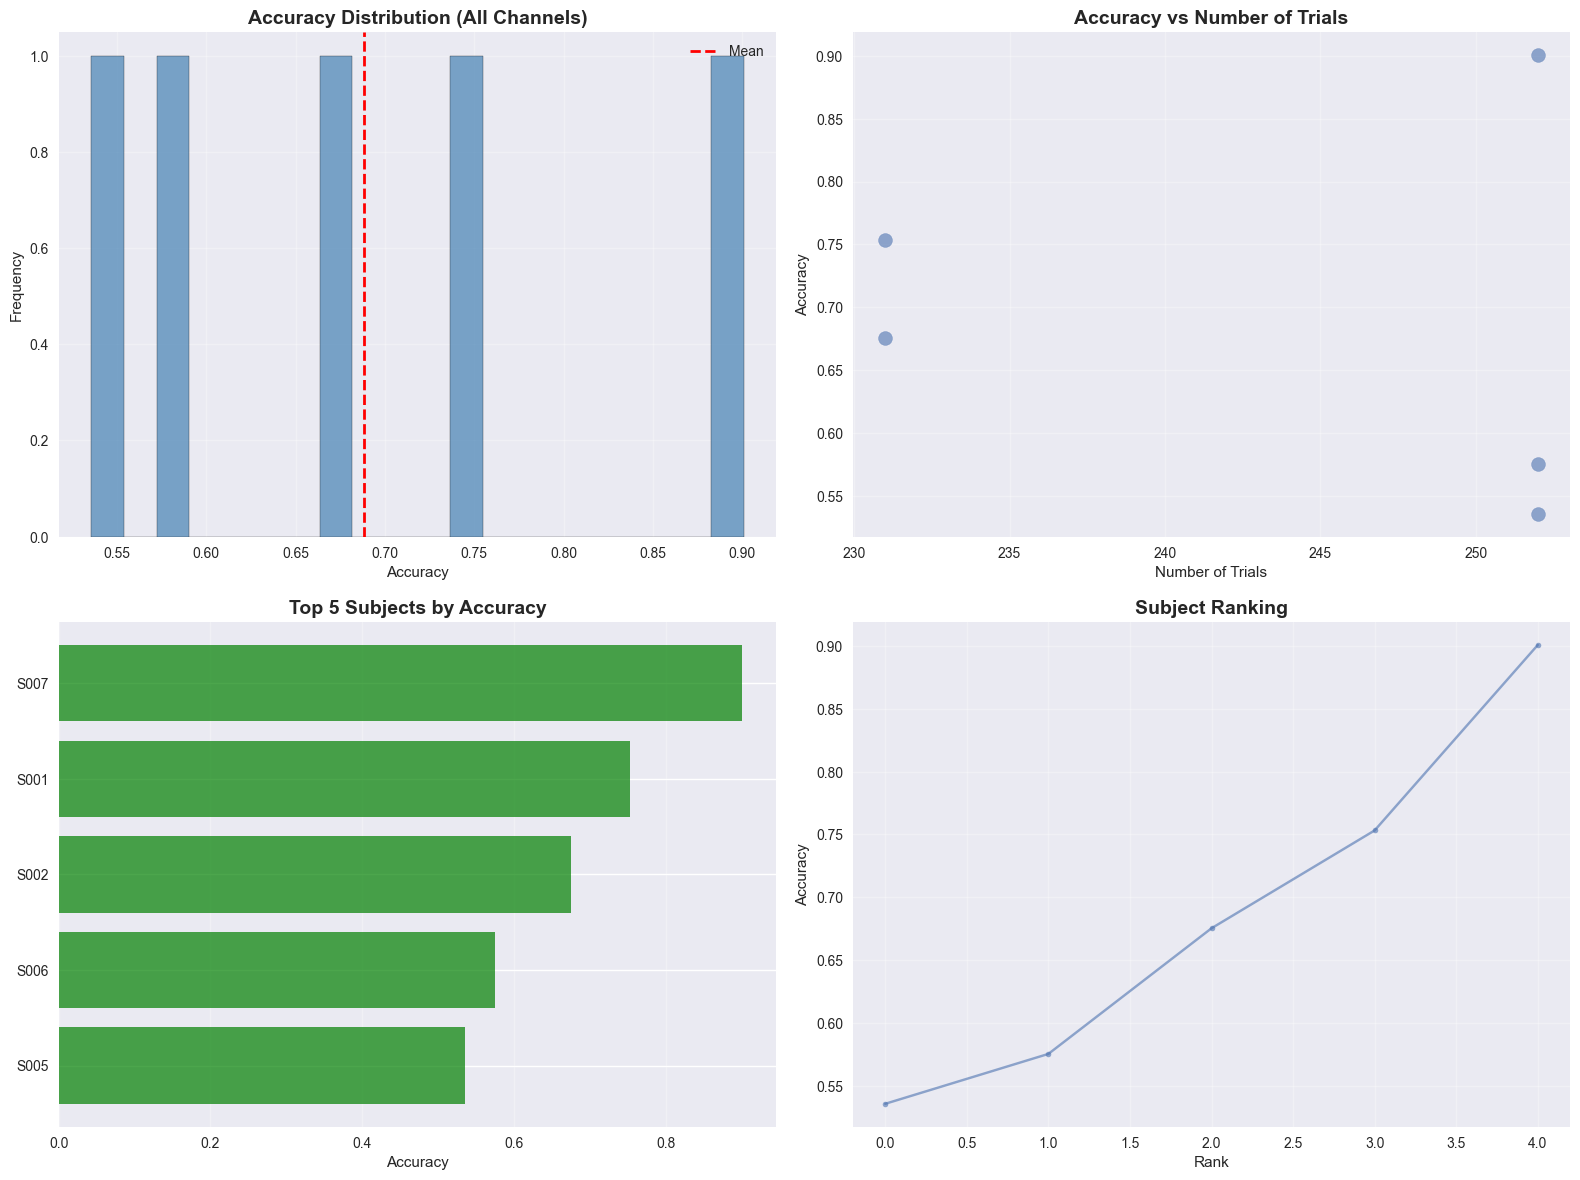

Visualizations saved to: results


In [33]:
if len(results_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Accuracy distribution
    axes[0, 0].hist(results_df['all_channels_acc'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(results_df['all_channels_acc'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0, 0].set_title('Accuracy Distribution (All Channels)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Accuracy')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy vs num trials
    axes[0, 1].scatter(results_df['num_trials'], results_df['all_channels_acc'], alpha=0.6, s=100)
    axes[0, 1].set_title('Accuracy vs Number of Trials', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Number of Trials')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].grid(True, alpha=0.3)

    # Top 10 subjects
    top_10 = results_df.nlargest(min(10, len(results_df)), 'all_channels_acc')
    axes[1, 0].barh(range(len(top_10)), top_10['all_channels_acc'], color='green', alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_10)))
    axes[1, 0].set_yticklabels(top_10['subject'])
    axes[1, 0].set_title(f'Top {len(top_10)} Subjects by Accuracy', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Accuracy')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(True, alpha=0.3, axis='x')

    # Subject ranking
    sorted_results = results_df.sort_values('all_channels_acc')
    axes[1, 1].plot(range(len(sorted_results)), sorted_results['all_channels_acc'], marker='o', markersize=4, alpha=0.6)
    axes[1, 1].set_title('Subject Ranking', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Rank')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(EXPERIMENT_CONFIG['output']['results_dir'] / 'results_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Visualizations saved to: {EXPERIMENT_CONFIG['output']['results_dir']}")
else:
    print("No results to visualize. Please ensure subjects were successfully trained.")

## Visualize Learned Adjacency Matrix (Example Subject)

Visualizing adjacency matrix for best subject: S007
Accuracy: 0.9008


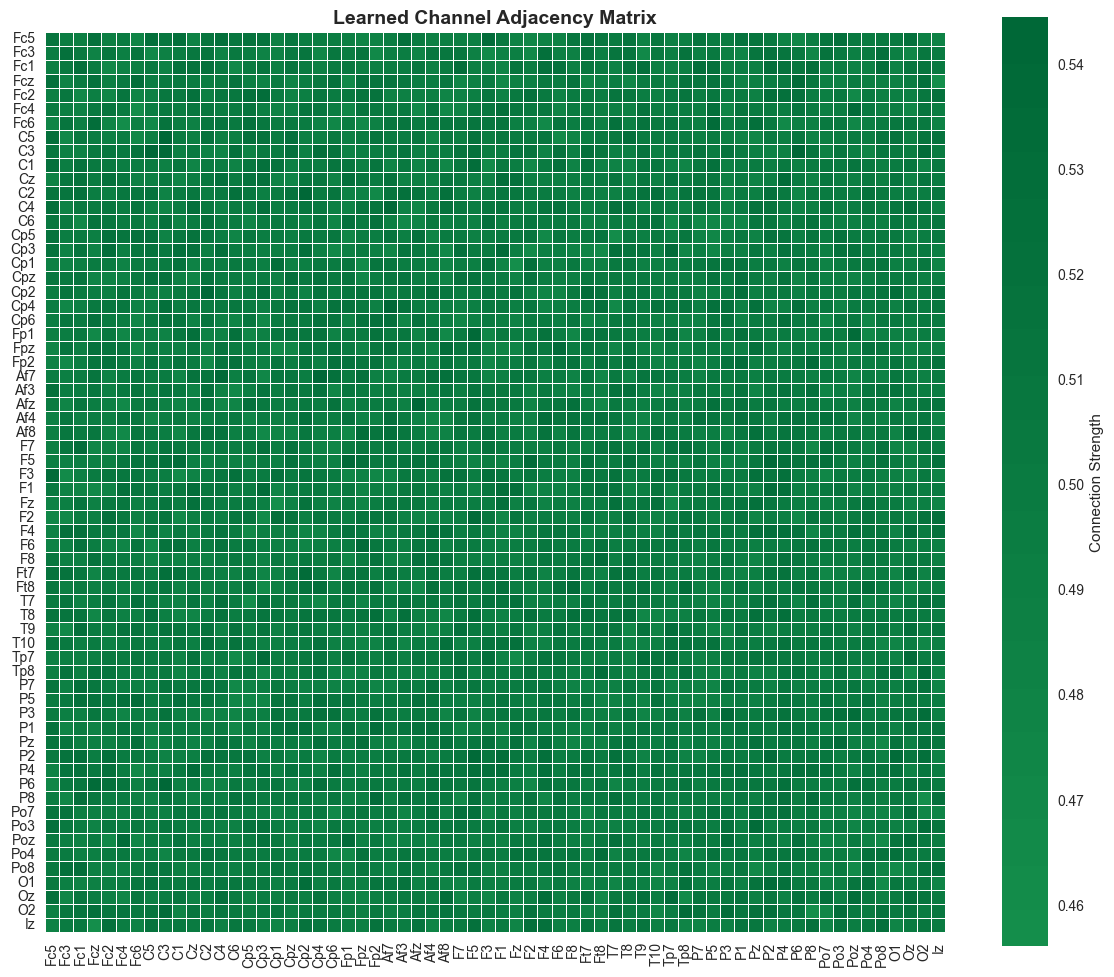


Top 10 Edges (Edge Selection):
Selected channels: ['Fc4', 'C5', 'C3', 'C2', 'C4', 'Cp2', 'Cp4', 'Fp1', 'Fp2', 'Af7', 'F5', 'Ft7', 'P2', 'P6', 'P8', 'Poz']

Top 10 Channels (Aggregation Selection):
Selected channels: ['C3', 'C2', 'C4', 'Cp2', 'F5', 'T8', 'P1', 'P2', 'P4', 'O2']


In [34]:
if len(all_results) > 0:
    # Pick best subject
    best_idx = results_df['all_channels_acc'].idxmax()
    best_result = all_results[best_idx]
    
    print(f"Visualizing adjacency matrix for best subject: {best_result['subject']}")
    print(f"Accuracy: {best_result['all_channels_acc']:.4f}")
    
    selector = ChannelSelector(best_result['adjacency_matrix'], best_result['channel_names'])
    
    fig = selector.visualize_adjacency(
        save_path=EXPERIMENT_CONFIG['output']['results_dir'] / f"adjacency_{best_result['subject']}.png"
    )
    plt.show()
    
    # Show top edges
    print("\nTop 10 Edges (Edge Selection):")
    selected_channels_es, _ = selector.edge_selection(10)
    print(f"Selected channels: {selected_channels_es}")
    
    print("\nTop 10 Channels (Aggregation Selection):")
    selected_channels_as, _ = selector.aggregation_selection(10)
    print(f"Selected channels: {selected_channels_as}")

## Export Results

In [36]:
if len(results_df) > 0:
    # Save subject results
    results_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'subject_results.csv'
    results_df[['subject', 'num_trials', 'num_channels', 'all_channels_acc', 'all_channels_std']].to_csv(results_path, index=False)
    
    # Save channel selection results
    if len(channel_selection_df) > 0:
        channel_selection_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'channel_selection_results.csv'
        channel_selection_df.to_csv(channel_selection_path, index=False)
    else:
        channel_selection_path = None
    
    # Save experiment config
    config_path = EXPERIMENT_CONFIG['output']['results_dir'] / 'experiment_config.json'
    with open(config_path, 'w') as f:
        json.dump(EXPERIMENT_CONFIG, f, indent=2, default=str)
    
    print("All results exported successfully!")
    print(f"  - Subject results: {results_path}")
    if channel_selection_path:
        print(f"  - Channel selection: {channel_selection_path}")
    print(f"  - Config: {config_path}")
else:
    print("No results to export.")

All results exported successfully!
  - Subject results: results\subject_results.csv
  - Channel selection: results\channel_selection_results.csv
  - Config: results\experiment_config.json
